In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

# import nltk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

In [2]:
import util as util

[nltk_data] Downloading package punkt to /home/bindra.p/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bindra.p/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bindra.p/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# get word embeddings from the gensim package
import gensim.downloader

# download the glove embeddings
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [4]:
TRAIN_PATH = '../dataset/SciHTC/train_title_abstract_keywords.csv'
TEST_PATH = '../dataset/SciHTC/test_title_abstract_keywords.csv'
# DEV_PATH = '../dataset/SciHTC/dev_title_abstract_keywords.csv'

# TRAIN_PATH = '/home/bindra.p/cs6140/Datasets/SciHTC/train_title_abstract_keywords.csv'
# TEST_PATH = '/home/bindra.p/cs6140/Datasets/SciHTC/test_title_abstract_keywords.csv'
# DEV_PATH = '/home/bindra.p/cs6140/Datasets/SciHTC/dev_title_abstract_keywords.csv'

In [5]:
MAX_LEN = 500
EMBEDDING_DIM = 50
# SAMPLE_SIZE = 18000

In [6]:
# read train and test data
train_df = util.read_data(TRAIN_PATH)
test_df = util.read_data(TEST_PATH)

input_cols = ['Title', 'Abstract']

# process the data and sample some for testing; it changes to df in place.
# Reload df if running again
train_df = util.preprocess_data(train_df, input_cols, 'Keywords', sample_size=None)
test_df = util.preprocess_data(test_df, input_cols, 'Keywords', sample_size=None)

# set up the tokenizer
tokenizer = util.setup_tokenizer(train_df, test_df, ['input_tokens', 'clean_kp'])

# create embeddings matrix
embeddings_matrix = util.get_embeddings_matrix(tokenizer, glove_vectors, EMBEDDING_DIM)

# create the input array
X_train, y_train = util.create_input_array(train_df, 'input_tokens', 'clean_kp', tokenizer,
                                           embeddings_matrix, EMBEDDING_DIM, MAX_LEN)

X_test, y_test = util.create_input_array(test_df, 'input_tokens', 'clean_kp', tokenizer,
                                            embeddings_matrix, EMBEDDING_DIM, MAX_LEN)

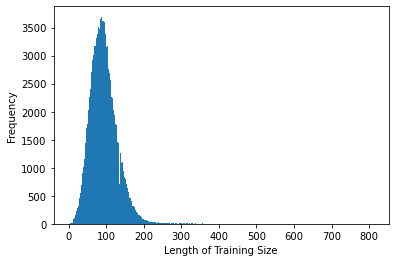

,count,mean,std,min,25%,50%,75%,95%,max
0,148928.0,94.02702,36.868197,1.0,69.0,90.0,114.0,156.0,811.0


In [9]:
train_size = []
for i in train_df['input_tokens']:
    train_size.append(len(i))
    
plt.hist(train_size, bins=len(set(train_size)))
plt.xlabel('Length of Training Size')
plt.ylabel('Frequency')
plt.show()

pd.DataFrame(np.array(train_size)).describe(percentiles = [.25, .5, .75, .95]).transpose()

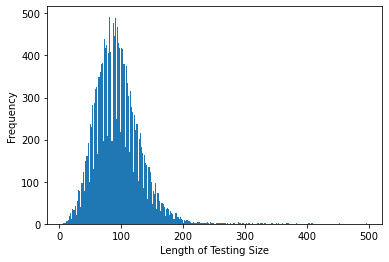

,count,mean,std,min,25%,50%,75%,95%,max
0,18616.0,94.053234,36.675551,5.0,69.0,91.0,114.0,157.0,497.0


In [10]:
test_size = []
for i in test_df['input_tokens']:
    test_size.append(len(i))
    
plt.hist(test_size, bins=len(set(test_size)))
plt.xlabel('Length of Testing Size')
plt.ylabel('Frequency')
plt.show()

pd.DataFrame(np.array(test_size)).describe(percentiles = [.25, .5, .75, .95]).transpose()

In [16]:
# build bi-LSTM model
model = Sequential()

# Shujun
# model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(MAX_LEN, EMBEDDING_DIM)))
# model.add(Bidirectional(LSTM(64)))
# model.add(Dense(MAX_LEN, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.3), input_shape=(MAX_LEN, EMBEDDING_DIM)))
model.add(Bidirectional(LSTM(32, dropout=0.2)))
model.add(Dense(MAX_LEN, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 500, 64)           21248     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 500)               32500     
                                                                 
Total params: 78580 (306.95 KB)
Trainable params: 78580 (306.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# fit model
model_data = model.fit(X_train, y_train, epochs=5, verbose=1)

Epoch 1/5
4654/4654 [==============================] - 1143s 244ms/step - loss: 0.0915 - accuracy: 0.1778
Epoch 2/5
4654/4654 [==============================] - 1121s 241ms/step - loss: 0.0816 - accuracy: 0.1815
Epoch 3/5
4654/4654 [==============================] - 1117s 240ms/step - loss: 0.0795 - accuracy: 0.1869
Epoch 4/5
4654/4654 [==============================] - 1114s 239ms/step - loss: 0.0790 - accuracy: 0.2016
Epoch 5/5
4654/4654 [==============================] - 1114s 239ms/step - loss: 0.0786 - accuracy: 0.2068


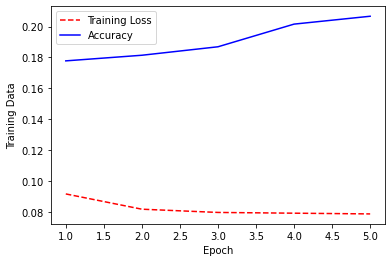

In [18]:
loss = model_data.history['loss']
acc = model_data.history['accuracy']
epoch_count = range(1, len(loss) + 1)

# Visualize graph
plt.plot(epoch_count, loss, 'r--')
plt.plot(epoch_count, acc, 'b-')
plt.legend(['Training Loss', 'Accuracy'])
plt.xlabel('Epoch')  
plt.ylabel('Training Data')
plt.show()

In [19]:
# model.save('/home/bindra.p/cs6140/bi_lstm_model_3')

INFO:tensorflow:Assets written to: /home/bindra.p/cs6140/bi_lstm_model_3/assets


INFO:tensorflow:Assets written to: /home/bindra.p/cs6140/bi_lstm_model_3/assets


In [11]:
model_1 = tf.keras.models.load_model('bi_lstm_model_1')
model_2 = tf.keras.models.load_model('bi_lstm_model_2')
model_3 = tf.keras.models.load_model('bi_lstm_model_3')

In [12]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 500, 128)          58880     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 500)               64500     
                                                                 
Total params: 222196 (867.95 KB)
Trainable params: 222196 (867.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 500, 64)           21248     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 500)               32500     
                                                                 
Total params: 78580 (306.95 KB)
Trainable params: 78580 (306.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 500, 64)           21248     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 500)               32500     
                                                                 
Total params: 78580 (306.95 KB)
Trainable params: 78580 (306.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
# testing prediction - MODEL 1
preds = model_1.predict(X_test)

# print prediction
pred_kws = util.pred_to_keywords(preds, test_df['input_tokens'].values, threshold=0.35)
pred_kws[:5]

582/582 [==============================] - 52s 90ms/step


[['eda', 'mooc', 'massive'],
 ['public', 'participation', 'despite'],
 ['vote', 'work', 'describe'],
 ['electromagnetism', 'multi-objective', 'evolutionary'],
 ['constraint', 'creative', 'process']]

In [42]:
# testing prediction - MODEL 2
preds = model_2.predict(X_test)
    
# print prediction
pred_kws = util.pred_to_keywords(preds, test_df['input_tokens'].values, threshold=0.35)
pred_kws[:5]

582/582 [==============================] - 34s 58ms/step


[['eda', 'mooc', 'massive', 'open'],
 ['public', 'participation', 'despite', 'many'],
 ['vote', 'work', 'describe', 'conversation'],
 ['electromagnetism', 'multi-objective', 'evolutionary', 'algorithm'],
 ['constraint', 'creative', 'process', 'digital']]

In [45]:
# testing prediction - MODEL 3
preds = model_3.predict(X_test)
    
# print prediction
pred_kws = util.pred_to_keywords(preds, test_df['input_tokens'].values, threshold=0.35)
pred_kws[:5]

582/582 [==============================] - 36s 62ms/step


[['mooc', 'massive', 'open'],
 ['gamers', 'public'],
 [],
 ['hybridization',
  'electromagnetism',
  'multi-objective',
  'evolutionary',
  'algorithm',
  'rcpsp'],
 ['freedom', 'constraint', 'creative', 'process', 'digital']]